# Visualize trajectories in Foxglove

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import math

import matplotlib.pyplot as plt
import geojson
from shapely.geometry import LineString
import numpy as np

from mcap_protobuf.writer import Writer
from foxglove_schemas_protobuf.CompressedImage_pb2 import CompressedImage
from foxglove_schemas_protobuf.LocationFix_pb2 import LocationFix

from google.protobuf.timestamp_pb2 import Timestamp
from google.protobuf.duration_pb2 import Duration

from utils import write_mcap_file

## Single GPS trajectory

In [3]:
trajectory_path = pathlib.Path("data/example_trajectory.geojson")

In [4]:
trajectory_path_as_geojson = geojson.loads(trajectory_path.read_text())

In [5]:
gps_path = LineString(trajectory_path_as_geojson["features"][0]["geometry"]["coordinates"])

In [6]:
num_samples = len(gps_path.coords)
print(num_samples)

13


In [7]:
timesteps = np.arange(0, num_samples)

In [8]:
gps_lon, gps_lat  = gps_path.coords.xy

### Interpolate for smooth visualization

In [9]:
FPS = 30
timesteps_for_viz = np.arange(0, num_samples, 1/FPS)

In [10]:
gps_lon_interp = np.interp(timesteps_for_viz, timesteps, gps_lon)
gps_lat_interp = np.interp(timesteps_for_viz, timesteps, gps_lat)

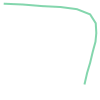

In [11]:
gps_path_for_viz = LineString(np.c_[gps_lon_interp, gps_lat_interp])
gps_path_for_viz

### Create an array of LocationFix messages

In [12]:
gps_message_array = list()

for t, gps_lon, gps_lat in zip(timesteps_for_viz, gps_lon_interp, gps_lat_interp):

    timestamp_pb2 = Timestamp(seconds=int(math.floor(t)), nanos=int(t*1e9 % 1e9))
    loc_fix_msg = LocationFix(timestamp=timestamp_pb2, frame_id="world", longitude=gps_lon, latitude=gps_lat, altitude=0)

    gps_message_array.append(loc_fix_msg)

## Object trajectories (cut-in)

In [13]:
from utils import create_cut_in_trajectories

In [14]:
vehicle_data = {}

df_veh_1, df_veh_2 = create_cut_in_trajectories()

vehicle_data["V1"] = df_veh_1
vehicle_data["V2"] = df_veh_2

vehicle_colors = {}
vehicle_colors["V1"] = "blue"
vehicle_colors["V2"] = "red"

In [15]:
vehicle_data["V2"].head()

,x,y,theta
0.0,0.0,3.999818,-0.000011
0.1,3.5,3.999778,-0.000014
0.2,7.0,3.999729,-0.000017
0.3,10.5,3.999669,-0.000021
0.4,14.0,3.999596,-0.000026


Text(0, 0.5, 'y [m]')

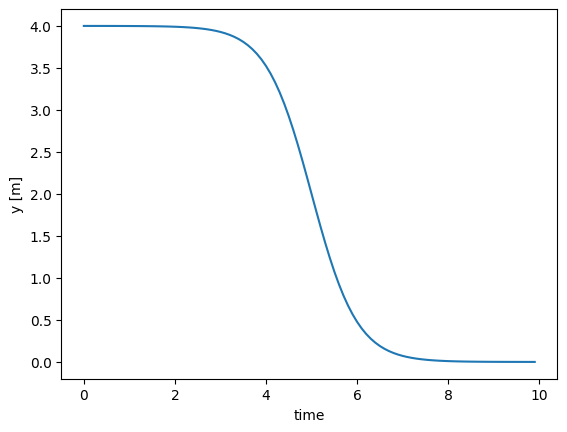

In [16]:
plt.plot(df_veh_2["y"])
plt.xlabel("time")
plt.ylabel("y [m]")

### Create Foxglove entity bounding boxes

This is later visualized

In [17]:
from utils import create_vehicle_cuboid

In [18]:
from foxglove_schemas_protobuf.SceneEntity_pb2 import SceneEntity
from foxglove_schemas_protobuf.SceneUpdate_pb2 import SceneUpdate
from foxglove_schemas_protobuf.CubePrimitive_pb2 import CubePrimitive

In [19]:
scene_updates = list()

timesteps = df_veh_1.index.array

for i, time in enumerate(timesteps):

    scene_entities = list()

    timestamp_pb2 = Timestamp(seconds=int(math.floor(t)), nanos=int(t*1e9 % 1e9))

    for veh_id, veh_df in vehicle_data.items():

        veh_sample = veh_df.loc[time]

        cube = create_vehicle_cuboid(veh_sample["x"], veh_sample["y"], 0.0, veh_sample["theta"], vehicle_colors[veh_id], alpha=0.5)
        assert isinstance(cube, CubePrimitive)

        scene_entity_foxglove = SceneEntity(id=veh_id, frame_id="world", timestamp=timestamp_pb2, frame_locked=False, cubes=[cube])

        scene_entities.append(scene_entity_foxglove)
    
    scene_update_foxglove = SceneUpdate(entities=scene_entities)
    scene_updates.append(scene_update_foxglove)

len(scene_updates)

100

## HD map

In [20]:
from foxglove_schemas_protobuf.LinePrimitive_pb2 import LinePrimitive
from foxglove_schemas_protobuf.Point3_pb2 import Point3

In [21]:
LANE_WIDTH = 4.0

In [22]:
right_marker_line = LineString([(-100, -LANE_WIDTH/2), (500,-LANE_WIDTH/2)])
center_marker_line = LineString([(-100, LANE_WIDTH/2), (500,LANE_WIDTH/2)])
left_marker_line = LineString([(-100, LANE_WIDTH+LANE_WIDTH/2), (500, LANE_WIDTH + LANE_WIDTH/2)])

In [23]:
def line_string_to_lineprimitive(linestring: LineString) -> LinePrimitive:
    return LinePrimitive(type=0, thickness=0.05, scale_invariant=False, 
                                   points=[Point3(x=coord[0], y=coord[1], z=0) for coord in linestring.coords])

In [24]:
right_lane_marking = line_string_to_lineprimitive(right_marker_line)
center_lane_marking = line_string_to_lineprimitive(center_marker_line)
left_lane_marking = line_string_to_lineprimitive(left_marker_line)

In [25]:
map_entity = SceneEntity(id="hd-map", frame_id="world", timestamp=Timestamp(seconds=0, nanos=0), frame_locked=False, 
                         lines=[right_lane_marking, center_lane_marking, left_lane_marking])
map_scene_update_foxglove = SceneUpdate(entities=[map_entity])

## Create frame transformation data

In [26]:
from foxglove_schemas_protobuf.FrameTransforms_pb2 import FrameTransforms
from foxglove_schemas_protobuf.FrameTransform_pb2 import FrameTransform
from foxglove_schemas_protobuf.Vector3_pb2 import Vector3
from foxglove_schemas_protobuf.Quaternion_pb2 import Quaternion

from scipy.spatial.transform import Rotation

In [27]:
frame_transform_pb2 = FrameTransform(timestamp=Timestamp(seconds=0, nanos=0), 
               parent_frame_id="world", child_frame_id="world",
               translation=Vector3(x=0, y=0, z=0), rotation=Quaternion(x=0.0, y=0.0, z=0.0, w=1.0))
frame_transforms_pb2 = FrameTransforms(transforms=[frame_transform_pb2])

In [28]:
frame_transforms_foxglove = list()

VEHICLE_HEIGHT = 1.5

for t, ego_sample in vehicle_data["V1"].iterrows():

    rot = Rotation.from_euler("zyx", [ego_sample["theta"], 0, 0], degrees=False)
    quat = rot.as_quat()
    quat_foxglove = Quaternion(x=quat[0], y=quat[1], z=quat[2], w=quat[3])

    timestamp_pb2 = Timestamp(seconds=int(math.floor(t)), nanos=int(t*1e9 % 1e9))

    frame_transform_pb2 = FrameTransform(timestamp=timestamp_pb2, 
               parent_frame_id="world", child_frame_id="V1",
               translation=Vector3(x=ego_sample["x"], y=ego_sample["y"], z= VEHICLE_HEIGHT/2),
               rotation=quat_foxglove)
    frame_transforms_pb2 = FrameTransforms(transforms=[frame_transform_pb2])

    frame_transforms_foxglove.append(frame_transforms_pb2)

In [29]:
from utils import write_mcap_file, TopicWithData

from foxglove_schemas_protobuf.KeyValuePair_pb2 import KeyValuePair

In [30]:
write_mcap_file("bboxes.mcap", [
    TopicWithData("/tf", timesteps, frame_transforms_foxglove),
    TopicWithData("/objects", timesteps, scene_updates),
    # state over time
    TopicWithData("/enum_topic", [0.0, 3.0, 7.0, 10.0], [KeyValuePair(key="state", value="CRUISING"), 
                                                   KeyValuePair(key="state", value="CHANGING LANE"), 
                                                   KeyValuePair(key="state", value="CRUISING"),
                                                   KeyValuePair(key="state", value="CRUISING")
                                                   ]),
    TopicWithData("/semantic_map", [0], [map_scene_update_foxglove]),
    TopicWithData("/gps_location", timesteps_for_viz, gps_message_array)
])